In [1]:
import cv2
import glob
import os
import math
import numpy as np
from PIL import Image, ImageDraw, ImageFont  # Python Imaging Library
from IPython.display import display, clear_output
import IPython.display

In [2]:
def plot_images(frame_size=(400, 250), columns=2, **kwargs):
    """
    Display multiple images in a grid with labels.
    
    Args:
        frame_size: Size for each image
        columns: Number of columns in the grid
        **kwargs: Dictionary of images with labels as keys
    
    Example:
        plot_images(**{"Original": img1, "Blurred": img2, "Edges": img3})
    """
    if not kwargs:
        print("No images provided!")
        return None
    
    images = []
    labels = []
    
    for label, frame in kwargs.items():
        # Ensure images are uint8
        if frame.dtype != np.uint8:
            frame = (frame * 255).astype(np.uint8)
        
        # Handle grayscale images
        if len(frame.shape) == 2:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, frame_size)
        
        images.append(Image.fromarray(frame))
        labels.append(label)
    
    # Calculate grid dimensions
    cols = max(1, columns)
    rows = int(np.ceil(len(images) / cols))
    
    # Create canvas
    label_height = 40
    combined_width = frame_size[0] * cols
    combined_height = rows * (frame_size[1] + label_height)
    combined_img = Image.new("RGB", (combined_width, combined_height), (255, 255, 255))
    
    # Draw images and labels
    draw = ImageDraw.Draw(combined_img)
    try:
        font = ImageFont.truetype("arial.ttf", 18)
    except:
        font = ImageFont.load_default()
    
    for idx, (img_pil, label) in enumerate(zip(images, labels)):
        row = idx // cols
        col = idx % cols
        x_offset = col * frame_size[0]
        y_offset = row * (frame_size[1] + label_height)
        
        # Draw label
        draw.text((x_offset + 10, y_offset + 10), label, fill="black", font=font)
        
        # Paste image
        combined_img.paste(img_pil, (x_offset, y_offset + label_height))

    display(combined_img)
    
    return combined_img

In [3]:
def detect_edges_canny(img, low_thresh=50, high_thresh=150):
    """Detect edges using Canny edge detector."""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        gray = gray[:, :, 2]  # Use the V channel
    else:
        gray = img
    return cv2.Canny(gray, low_thresh, high_thresh)

def detect_edges_sobel(img):
    """Detect edges using Sobel operator."""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        gray = gray[:, :, 2]  # Use the V channel
    else:
        gray = img
    
    # Compute gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute magnitude
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = np.uint8(255 * magnitude / np.max(magnitude))
    
    return magnitude

def detect_edges_laplacian(img):
    """Detect edges using Laplacian."""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        gray = gray[:, :, 2]  # Use the V channel
    else:
        gray = img
    
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

In [4]:
def apply_clahe(img, clip_limit=2.0, tile_size=(8, 8)):
    """Apply CLAHE for adaptive contrast enhancement."""
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    l_enhanced = clahe.apply(l)
    
    # Merge back
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    return cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

In [5]:
def gamma_correction(image, gamma=1.2):
    """Apply gamma correction"""
    inv_gamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** inv_gamma) * 255
        for i in np.arange(0, 256)
    ]).astype("uint8")
    return cv2.LUT(image, table)


def intensity_normalization(image):
    """Normalize intensity to full [0,255] range"""
    normalized = cv2.normalize(
        image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
    )
    return normalized

def binary_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    return(cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR))

def otsu_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, otsu = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
    return(cv2.cvtColor(otsu, cv2.COLOR_GRAY2BGR))

def adaptive_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    return(cv2.cvtColor(adaptive, cv2.COLOR_GRAY2BGR))

def erosion(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Erosion - removes small white regions
    eroded = cv2.erode(gray, kernel, iterations=1)
    return(cv2.cvtColor(eroded, cv2.COLOR_GRAY2BGR))

def dilation(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    
    # Erosion - removes small white regions
    dilated = cv2.dilate(image, kernel, iterations=1)
    return(cv2.cvtColor(dilated, cv2.COLOR_GRAY2BGR))

def closing(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Erosion - removes small white regions
    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    return(cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR))

def opening(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Erosion - removes small white regions
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    return(cv2.cvtColor(opened, cv2.COLOR_GRAY2BGR))

In [ ]:
def bbox_from_contour(cnt):
    return cv2.boundingRect(cnt)


def bbox_center(b):
    x, y, w, h = b
    return np.array([x + w/2, y + h/2])


def contour_center_x(cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    return x + w / 2


def vertically_aligned(b1, b2, x_thresh=30):
    return abs(bbox_center(b1)[0] - bbox_center(b2)[0]) < x_thresh


def close_vertically(b1, b2, y_thresh=60):
    y1 = b1[1] + b1[3]
    y2 = b2[1]
    return abs(y2 - y1) < y_thresh or abs(y1 - y2) < y_thresh


def merge_contours(contours):
    return np.vstack(contours)


def is_cone_shape(cnt):

    area = cv2.contourArea(cnt)
    if area < 500:
        return False

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = h / w if w > 0 else 0

    hull = cv2.convexHull(cnt)
    solidity = area / cv2.contourArea(hull)

    ys = cnt[:, 0, 1]
    xs = cnt[:, 0, 0]

    top = xs[ys < y + 0.25 * h]
    bottom = xs[ys > y + 0.75 * h]

    if len(top) < 5 or len(bottom) < 5:
        return False
    left = cnt[:, :w//2]
    right = cnt[:, w//2:]

    symmetry = abs(np.sum(left) - np.sum(right)) / area
    if symmetry > 0.3:
        return False
    

    return (
        aspect_ratio > 1.4 and
        solidity > 0.65 and
        np.ptp(bottom) > np.ptp(top)
    )





def cone_color(bgr_roi):
    """
    Robust cone color classification using HSV + LAB chroma + pixel voting.

    Returns one of:
    'orange','yellow','green','blue','pink','unknown'
    """

    if bgr_roi is None or bgr_roi.size == 0:
        return "unknown"

    # --- Convert spaces ---
    hsv = cv2.cvtColor(bgr_roi, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lab = cv2.cvtColor(bgr_roi, cv2.COLOR_BGR2LAB)
    _, a_chan, b_chan = cv2.split(lab)
    chroma = np.maximum(
        cv2.absdiff(a_chan, 128),
        cv2.absdiff(b_chan, 128)
    )

    # --- Reject low-color pixels (sand / shadow) ---
    valid = (s > 50) & (v > 50) & (chroma > 18)

    if np.count_nonzero(valid) < 0.05 * h.size:
        return "unknown"

    h = h[valid]
    s = s[valid]
    v = v[valid]

    # --- Color rules: H + S + V together ---
    color_rules = {
        "orange": ( (0, 20),   70,  80 ),
        "yellow": ( (20, 35),  60,  90 ),
        "green":  ( (35, 85),  50,  60 ),
        "blue":   ( (90, 130), 50,  50 ),
        "pink":   ( (140,170), 60,  80 )
    }

    scores = {}

    for color, (h_rng, s_min, v_min) in color_rules.items():
        h_mask = (h >= h_rng[0]) & (h <= h_rng[1])
        s_mask = (s >= s_min)
        v_mask = (v >= v_min)

        mask = h_mask & s_mask & v_mask
        scores[color] = np.count_nonzero(mask)

    best_color = max(scores, key=scores.get)
    best_score = scores[best_color]

    # Require dominance
    if best_score < 0.15 * h.size:
        return "unknown"

    return best_color






def contour_width(cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    return w


def is_possible_cone(cnt):
    area = cv2.contourArea(cnt)
    if area < 150:
        return False

    x, y, w, h = cv2.boundingRect(cnt)
    return h > 1.1 * w


def is_strong_cone_shape(img,cnt):
    area = cv2.contourArea(cnt)

    # Skip strict checks for far cones
    # if area < 1200:
    #     return True

    h2, w2 = img.shape[:2]
    image_area = h2 * w2

    if area/image_area>0.75:
        print("Area check failed:", area/image_area)
        return False
    
    x, y, w, h = cv2.boundingRect(cnt)

    # Basic aspect ratio check (cones are tall-ish)
    if h < 1.1 * w or h > 4.5 * w:
        print("Aspect ratio check failed:", h / w)
        return False

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    ys = cnt[:, 0, 1]
    xs = cnt[:, 0, 0]

    # Looser vertical split
    top = xs[ys < y + 0.4 * h]
    bottom = xs[ys > y + 0.6 * h]

    if len(top) < 3 or len(bottom) < 3:
        return True  # Don't kill borderline cones


    roi = img[y:y+h, x:x+w]

    if roi.size == 0:
        return True

    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 160, apertureSize=3)

    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        

        minLineLength = int(max(0.25, min(1.0, h / 150)) * 0.4 * h),
        maxLineGap   = int(max(0.25, min(1.0, h / 150)) * 0.2 * h),
        threshold    = int(max(0.25, min(1.0, h / 150)) * 40)

    )

    if lines is None:
        print("No Hough lines found")
        return False

    slanted_vertical_lines = 0

    for l in lines:
        x1, y1, x2, y2 = l[0]
        dx = x2 - x1
        dy = y2 - y1

        if dx == 0:
            angle = 90
        else:
            angle = abs(np.degrees(np.arctan2(dy, dx)))

        # Near-vertical but slanted (cone sides)
        if 60 < angle < 120:
            length = np.hypot(dx, dy)
            if length > 0.4 * h:
                slanted_vertical_lines += 1

    if slanted_vertical_lines < 1:
        print("Hough validation failed:", slanted_vertical_lines)
        return False



    top_width = np.ptp(top)
    bottom_width = np.ptp(bottom)

    # Soft tapering rule
    return True
    # return bottom_width > 0.75 * top_width


def split_merged_contour(cnt, image, min_distance_ratio=0.45):
    """Attempt to split a wide/merged contour using watershed on distance transform.

    Returns a list of contours in the same coordinate space as the original image.
    """
    x, y, w, h = cv2.boundingRect(cnt)
    if w < 10 or h < 10:
        return [cnt]

    # Local mask for the contour region
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, -1, offset=(-x, -y))

    # Clean small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # Distance transform
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    if dist.max() <= 0:
        return [cnt]

    # Mark sure foreground from peaks in distance map
    _, sure_fg = cv2.threshold(dist, min_distance_ratio * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(mask, sure_fg)

    # Connected components for markers
    ret, markers = cv2.connectedComponents(sure_fg)
    if ret <= 1:
        return [cnt]

    markers = markers + 1
    markers[unknown == 255] = 0

    # Watershed requires a 3-channel image
    color_roi = image[y:y+h, x:x+w].copy()
    if color_roi.ndim == 2:
        color_roi = cv2.cvtColor(color_roi, cv2.COLOR_GRAY2BGR)

    markers = cv2.watershed(color_roi, markers.astype(np.int32))

    results = []
    max_marker = int(markers.max())
    for m in range(2, max_marker + 1):
        m_mask = (markers == m).astype(np.uint8) * 255
        if cv2.countNonZero(m_mask) < 30:
            continue
        contours_m, _ = cv2.findContours(m_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours_m:
            continue
        # shift contour to original image coords
        c = contours_m[0] + np.array([[[x, y]]])
        results.append(c.astype(np.int32))

    if len(results) == 0:
        return [cnt]

    return results


In [ ]:
#Images on which pipeline is working perfectly

path="Cone_images/82_jpg.rf.73edbdfd48e51a415b21d7139a683f9e.jpg"
path="Cone_images/img_11_jpg.rf.9a52c4f2918de2f997f5ff913ff03ed7.jpg"
path="Cone_images/img_7_jpg.rf.2b15fb6012fa9507f5410cdf9839f03a.jpg"
path="Cone_images/img_18_jpg.rf.101fbde30fe34112eeacbbd19c5c98d0.jpg"
path="Cone_images/img_25_jpg.rf.d1f9dee573dd1919c45f1a81414a928e.jpg"
path="Cone_images/img_10_jpg.rf.99e962ac4e5eb780ba4889457fd0e439.jpg"
path="Cone_images/img_17_jpg.rf.1a5f56c2fa77a48b21900759b0373f6f.jpg"
path="Cone_images/img_17_jpg.rf.78242b9d29aab8fbaf6b1a3f95b69e75.jpg"
path="Cone_images/img_14_jpg.rf.249d3aa09e05709f1a984013c207af5b.jpg"
path="Cone_images/img_5_jpg.rf.b2b8062892787810830b1b71539fd5a4.jpg"
path="Cone_images/img_14_jpg.rf.6c50ad5ea036dca0a77f5675602a3c48.jpg"
path="Cone_images/img_2_jpg.rf.72d29d2d1e4b041f66719acfd7f20e85.jpg"
path="Cone_images/img_1_jpg.rf.6a8953f0676be621b78ab65d00bf73b9.jpg"
path="Cone_images/img_23_jpg.rf.0eecf0045fffaec038958d444ed5089f.jpg"
path="Cone_images/img_16_jpg.rf.944eed1daf176c19fb698ec22417bd11.jpg"
path="Cone_images/250_jpg.rf.f35df075b47546dccff235a5ab58250e.jpg"
path="Cone_images/img_4_jpg.rf.ff93bce1d9961a4dfb31f3422556278c.jpg"
path="Cone_images/img_8_jpg.rf.e9474fb4399f40542df0f3dd026876ac.jpg"
path="Cone_images/img_21_jpg.rf.a707718754f687bbf989f0fdc0f6195f.jpg"

# ---------
# #images which have a few issues in detection
# path="Cone_images/239_jpg.rf.89b04d9b3750dd92c5cbe431e8c57ca2.jpg"
# path="Cone_images/BOY2_mp4-0043_jpg.rf.67457372a90d339329cc6ac8902816fe.jpg"
# path="Cone_images/221_jpg.rf.ad8fc5e4d739d4f2437fbef85e05c947.jpg"
# path="Cone_images/img_9_jpg.rf.c170b8d19235cca642703089afc4e3c3.jpg"
# path="Cone_images/img_24_jpg.rf.d82319091f817e4249e78c9fd6c8892f.jpg"
#path="Cone_images/102_jpg.rf.e62375dff883506772a024f60eb81f8d.jpg"
#path="Cone_images/BOY1_mp4-0019_jpg.rf.0efcdf763f58fe9512749981370bd803.jpg"
#path="Cone_images/im_47_jpg.rf.3beca64c3d2df8491f94e7c1faf6d1d0.jpg"

img = cv2.imread(path)


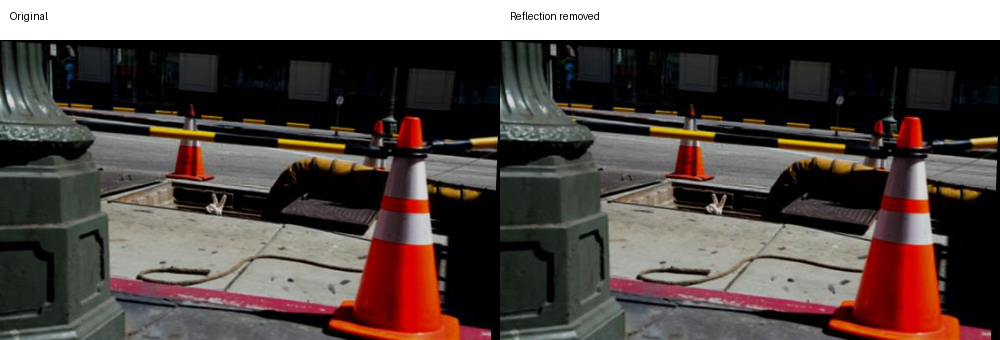

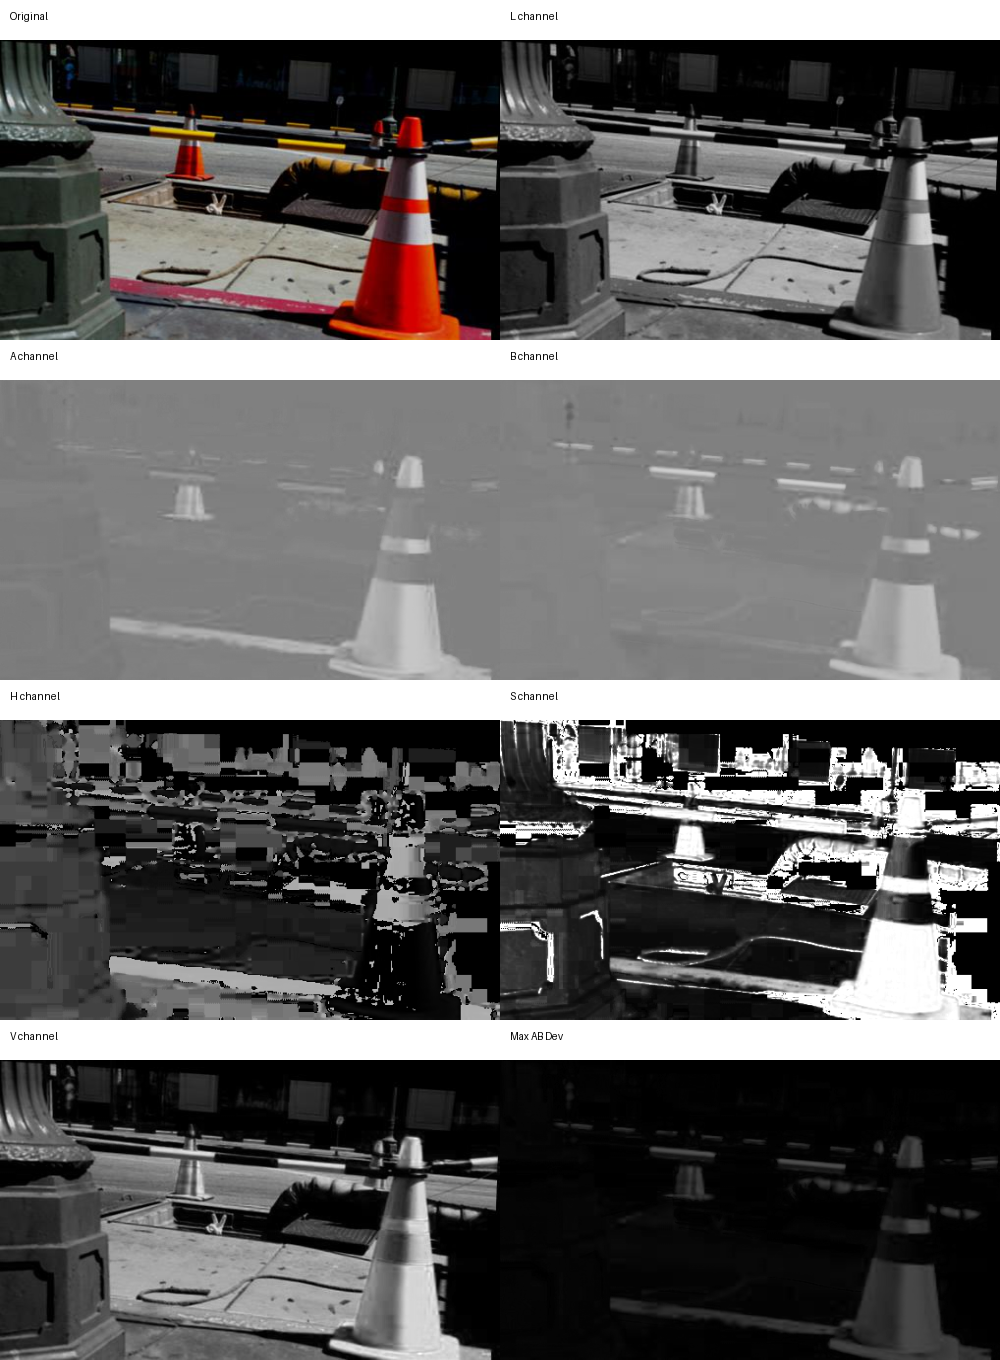

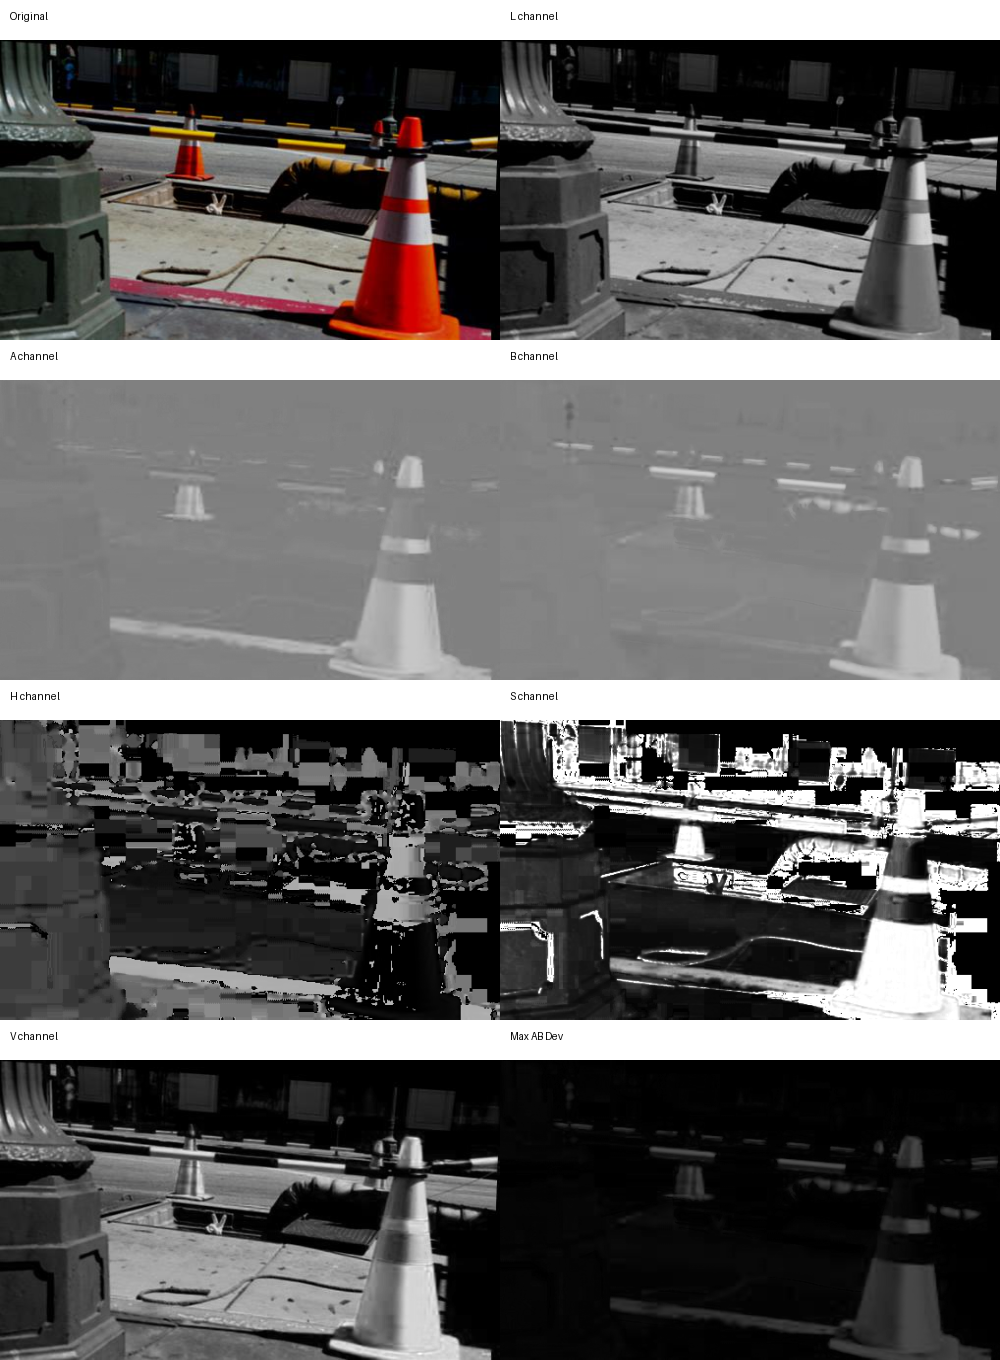

In [62]:
orig_img = img.copy()

# --------------------------------------
# Color space splits
# --------------------------------------
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab)

# Thresholds (you WILL tune these)
L_min = 220      # bright
A_min, A_max = 120, 136
B_min, B_max = 120, 136

white_mask = cv2.inRange(lab,
                          (L_min, A_min, B_min),
                          (255,   A_max, B_max))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)
white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel)

non_reflection_mask = cv2.bitwise_not(white_mask)

reflection_removed = cv2.bitwise_and(
    img, img, mask=non_reflection_mask
)

A_dev = cv2.absdiff(A, 128)
B_dev = cv2.absdiff(B, 128)

maxABdev = cv2.max(A_dev, B_dev)



plot_images(frame_size=(500,300), **{'Original': img, 'Reflection removed': reflection_removed,
                                     })

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(hsv)
plot_images(frame_size=(500,300), **{'Original': img, 'L channel': L, 'A channel': A, 'B channel': B,
                                     'H channel': H, 'S channel': S, 'V channel': V, 'Max AB Dev': maxABdev
                                     })



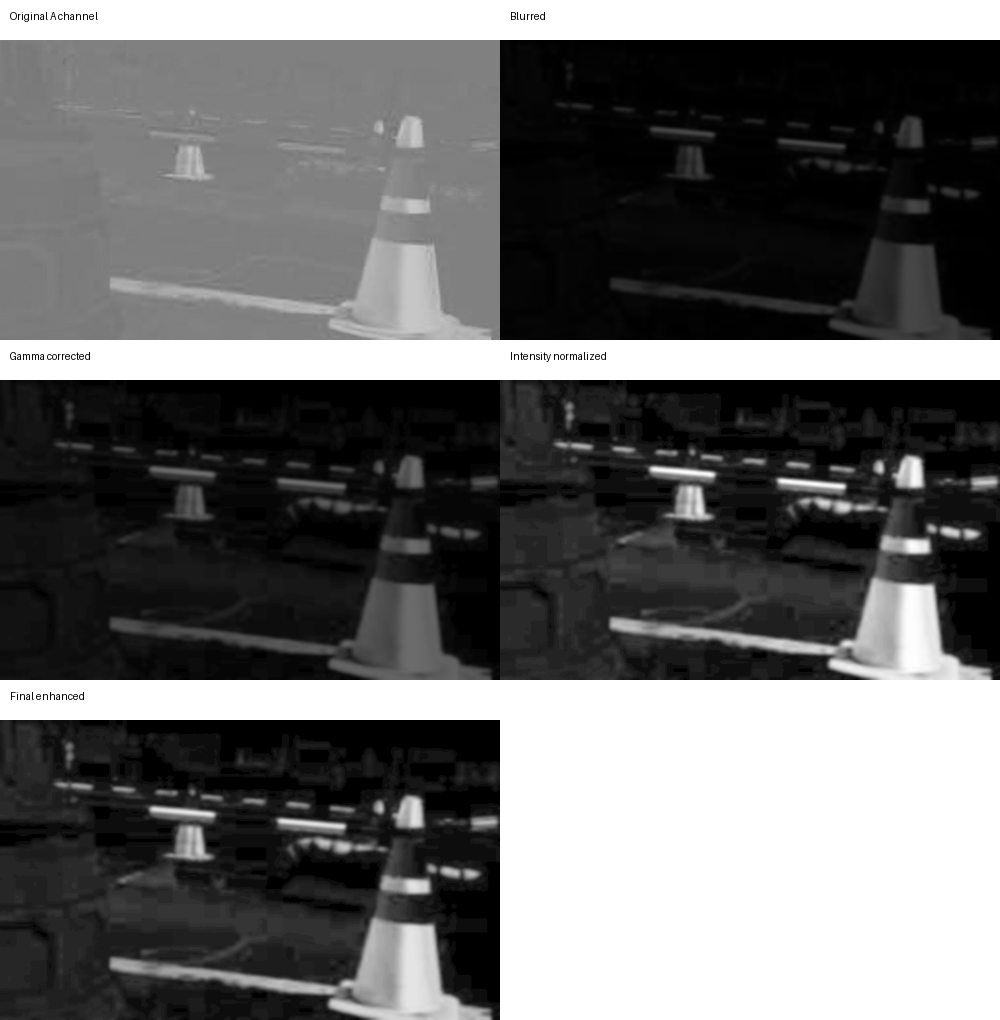

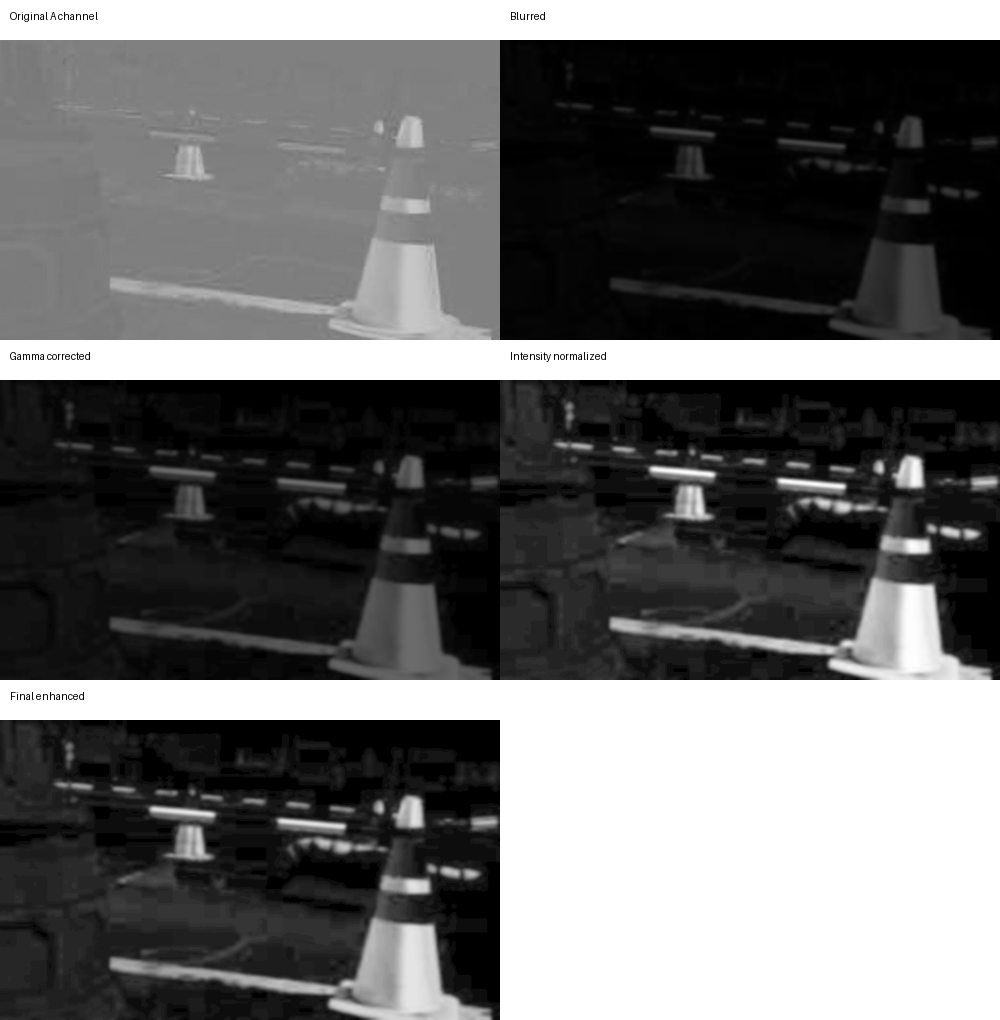

In [63]:
img1 = cv2.GaussianBlur(maxABdev, (7, 7), 0)
img2 = gamma_correction(img1, gamma=1.5)
img3 = intensity_normalization(img2)

img4 = cv2.convertScaleAbs(img3, alpha=0.9, beta=0)
img4 = img4.astype(np.uint8)
plot_images(frame_size=(500,300), **{'Original A channel': A, 'Blurred': img1,
                                     'Gamma corrected': img2, 'Intensity normalized': img3,
                                     'Final enhanced': img4})

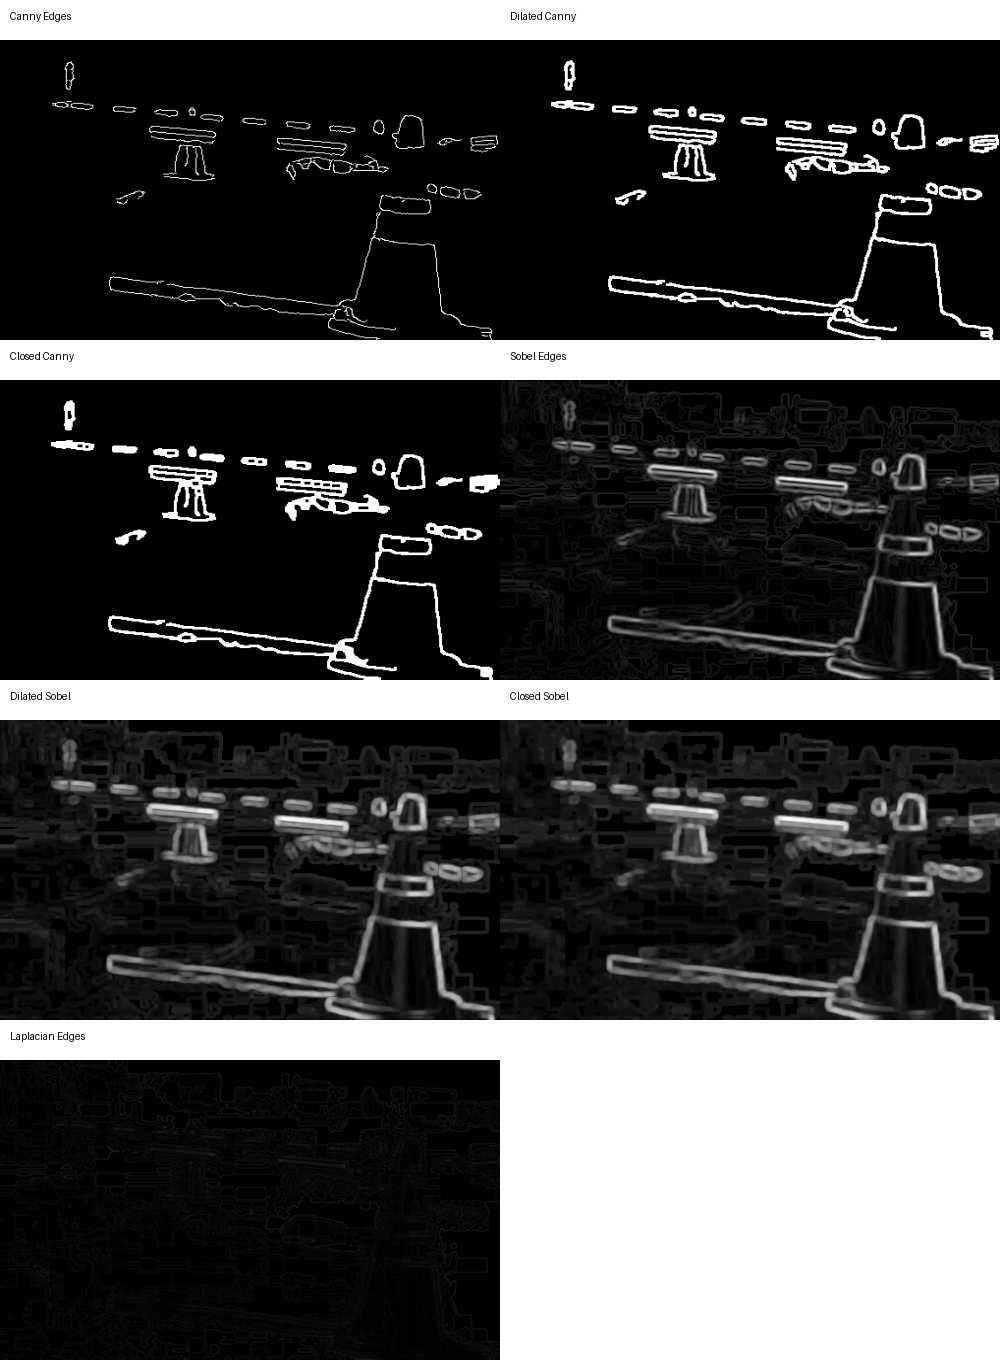

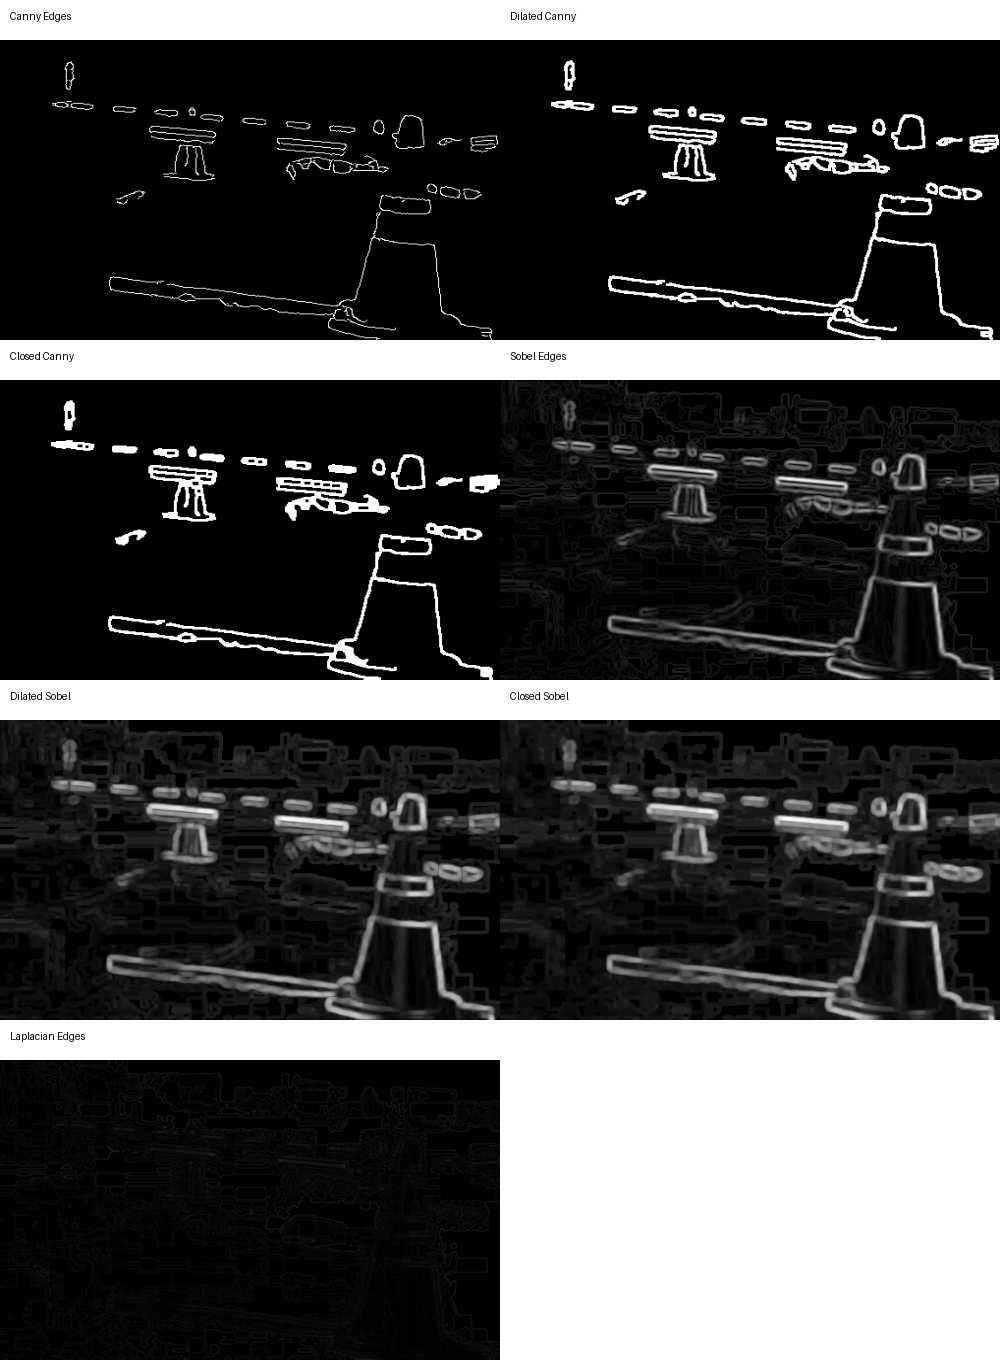

In [ ]:

edges_canny = detect_edges_canny(img4)
edges_sobel = detect_edges_sobel(img4)
edges_laplacian = detect_edges_laplacian(img4)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
edges_dilated = cv2.dilate(edges_canny, kernel, iterations=1)
edges_closed = cv2.morphologyEx(edges_dilated, cv2.MORPH_CLOSE, kernel)

edges_dialated2= cv2.dilate(edges_sobel, kernel, iterations=1)
edges_closed2 = cv2.morphologyEx(edges_dialated2, cv2.MORPH_CLOSE, kernel)

plot_images(frame_size=(500,300), **{'Canny Edges': edges_canny, 'Dilated Canny': edges_dilated,
                                     'Closed Canny': edges_closed,
                                     'Sobel Edges': edges_sobel, 'Dilated Sobel': edges_dialated2,
                                     'Closed Sobel': edges_closed2,
                                     'Laplacian Edges': edges_laplacian})

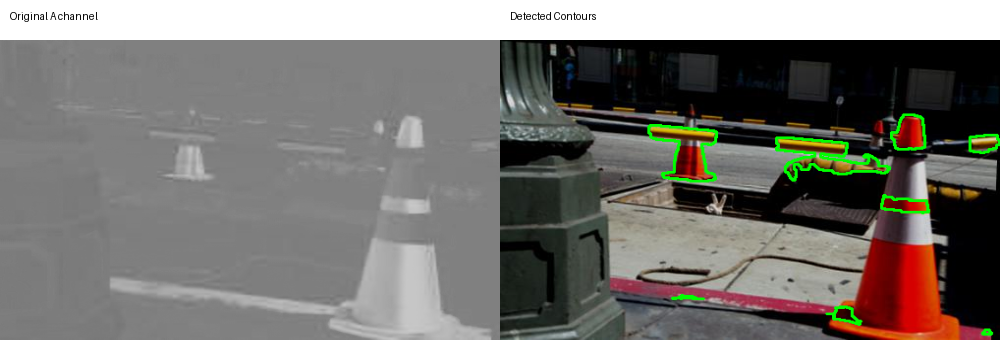

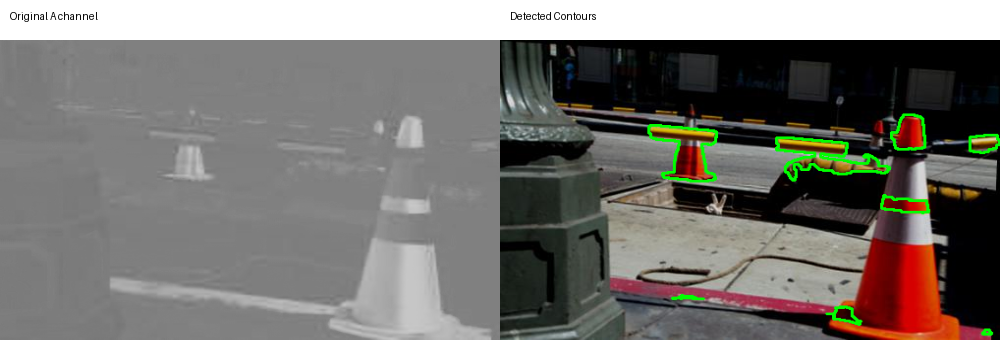

In [65]:
contours, _ = cv2.findContours(
        edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

contours = sorted(contours, key=contour_center_x)

filtered_contours = []

for cnt in contours:
    if cv2.contourArea(cnt) < 300:
        continue
    x, y, w, h = cv2.boundingRect(cnt)

    if h == 0:
        continue

    aspect_ratio = w / h   # width-to-height

    # Reject very wide contours that are unlikely to be cones 
    if aspect_ratio > 2.5:
        continue

    filtered_contours.append(cnt)

# Attempt to split wide/merged contours using watershed
processed_contours = []
for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > max(1.3 * h, 120):
        splits = split_merged_contour(cnt, orig_img)
        processed_contours.extend(splits)
    else:
        processed_contours.append(cnt)

plot_images(frame_size=(500,300), **{'Original A channel': A, 'Detected Contours': cv2.drawContours(orig_img.copy(), processed_contours, -1, (0,255,0), 2)})

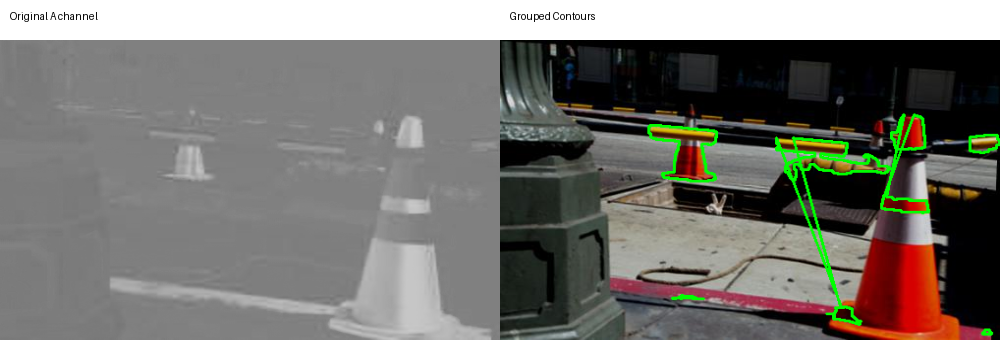

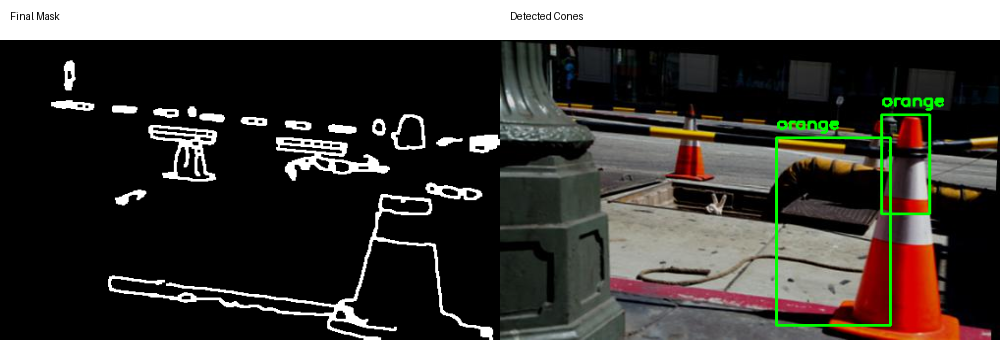

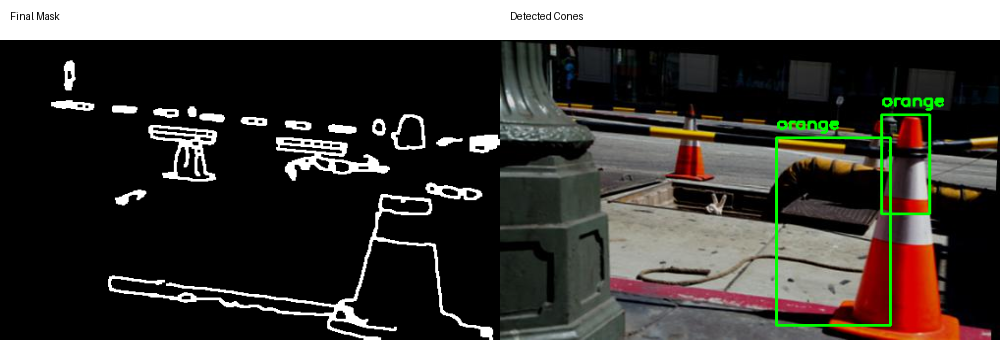

In [66]:



groups = []

for cnt in processed_contours:
    cx = contour_center_x(cnt)
    w = contour_width(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    
    roi = orig_img[y:y+h, x:x+w]
    color_cnt = cone_color(roi)


    placed = False
    for group in groups:
        x, y, w, h = cv2.boundingRect(group[0])
    
        roi = orig_img[y:y+h, x:x+w]
        color_group = cone_color(roi)

        gx = contour_center_x(group[0])
        gw = contour_width(group[0])

        x_thresh = max(0.45 * max(w, gw), 30)
        # NEW: color consistency check
        if color_cnt != color_group:
            continue
        if abs(cx - gx) < x_thresh:
            group.append(cnt)
            placed = True
            break

    if not placed:
        groups.append([cnt])

contour_info = []

plot_images(frame_size=(500,300), **{'Original A channel': A, 'Grouped Contours': cv2.drawContours(orig_img.copy(), [merge_contours(g) for g in groups], -1, (0,255,0), 2)})

# --------------------------------------
# Detection & Bounding Boxes
# --------------------------------------
output = orig_img.copy()

for group in groups:
    merged = merge_contours(group)

    if not is_possible_cone(merged):
        continue

    if not is_strong_cone_shape(img,merged):
        continue

    x, y, w, h = cv2.boundingRect(merged)
    
    roi = orig_img[y:y+h, x:x+w]
    color = cone_color(roi)

    cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 2)

    text_y = y - 10 if y - 10 > 10 else y + 20

    cv2.putText(
        output,
        color,
        (x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )


plot_images(frame_size=(500,300), **{'Final Mask': edges_closed, 'Detected Cones': output})